# Stage 3: Calculate the Attribution Scores via DINO Latent Similarity
This notebook calculates attribution scores using Meta's DINOv2 model to encode images in a latent space.
### Before attempting to run this notebook, make sure you already have:
- A trained model of interest (which can be obtained by running either train_sd1.sh or train_sd1_lora.sh in training_scripts/ \<dataset\>/)
- A test dataset of generated images from your model of interest, obtained by running SD1_Generate_Images.ipynb
- Existing DINOv2 cache, obtained by running DINO_conversion.ipynb

### What this notebook will do
This notebook will calculate attribution scores using DINO for the test dataset of generated images, and will then use this to generate a counter factual dataset, which you can use with training_scripts/ \<dataset\>/train_sd1_(lora_)counterfactuals.sh to generate a counter factual dataset. Once that is complete, rerun this script to generate a counter factual image.

In [1]:
from utils.config import Project_Config, CIFAR_10_Config, CIFAR_10_Local_Config, Model_Config
from utils.custom_enums import Dataset_Type_Enum, Model_Type_Enum

/home/joy/miniconda3/envs/SD3HF/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joy/miniconda3/envs/SD3HF/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/joy/miniconda3/envs/SD3HF/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


### Configuration
The following code block sets the configuartion for this run through.
- ```dataset_type```: either CIFAR10 or CIFAR2, specifies which dataset to use.

- ```model_type```: either LORA or FULL, specifies which type of model to use (i.e. which type of model to generate attribution scores for).

- ```project_config```: allows for specifiying machine specific settings, such as specific the current working directory, if to use CUDA, or if to use Windows or Unix like file paths. Rather than changing it here, you should go edit the defaults in utils/config.py/Project_Config.\_\_init__() .

In [2]:
dataset_type = Dataset_Type_Enum.CIFAR10
model_type = Model_Type_Enum.FULL
project_config = Project_Config()

This notebook should take roughly 4 minutes to run for any config (providing CUDA is enabled).

Next we setup our environment, creating the various config objects needed.

In [3]:
MODEL_NAME_CLEAN = f"sd1-{model_type}"

#Internal config, only for debugging
RECALCULATE_ATTRIBUTION = True
#LDS, currently non-functional
CALCULATE_LDS = False

f = project_config.folder_symbol
base_save_path = (project_config.PWD + f + 
                  "datasets" + f +
                  f"generated-{dataset_type}" + f +
                  MODEL_NAME_CLEAN)

if dataset_type == Dataset_Type_Enum.CIFAR10:
    train_dataset_config = CIFAR_10_Config()
if dataset_type == Dataset_Type_Enum.CIFAR2:
    train_dataset_config = CIFAR_10_Local_Config(
        project_config=project_config,
        dataset_type=dataset_type
    )
    
generated_dataset_config = CIFAR_10_Config(huggingface_slug=base_save_path, existing_image_column_name="image")

We sample some images from the test dataset to display. 
- ```NUM_SEEDS``` refers to the number of different seeds used to generate the test dataset of training images, and should match what you have already generated.
- ```SEED_TO_PREVIEW``` selects which of these seeds get shown, feel free to change this to see other images in the test set.

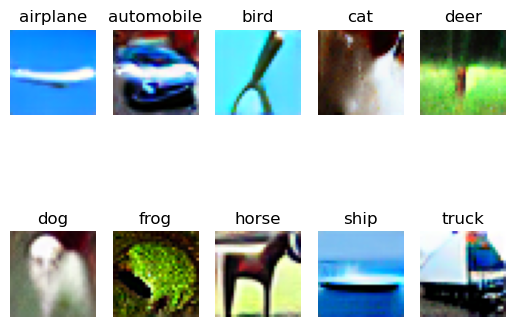

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

NUM_SEEDS = 20
SEED_TO_PREVIEW = 1
NUM_CLASSES = len(generated_dataset_config.class_captions)

generated_images = []

for subplot_i,i in enumerate(range(SEED_TO_PREVIEW,NUM_SEEDS*NUM_CLASSES,NUM_SEEDS)):
    plt.subplot(2, 5, subplot_i+1)
    plt.axis('off')
    plt.title(generated_dataset_config.dataset[i][generated_dataset_config.caption_column])
    plt.imshow(generated_dataset_config.dataset[i][generated_dataset_config.image_column])
    generated_images.append(generated_dataset_config.dataset[i][generated_dataset_config.image_column])

We sample some images from the training dataset, and display these.

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


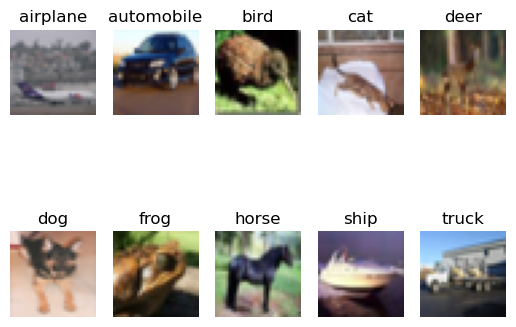

In [5]:
search_index = 0
prompts = train_dataset_config.class_captions
print(prompts)

for i in range(NUM_CLASSES):
    plt.subplot(2, NUM_CLASSES//2, i+1)
    plt.axis('off')

    #Train dataset is not in class order, so we will have to search
    prompt = prompts[i]
    search_index = 0
    while train_dataset_config.dataset[search_index][train_dataset_config.caption_column] != prompt:
        search_index += 1
    
    plt.title(train_dataset_config.dataset[search_index][train_dataset_config.caption_column])
    plt.imshow(train_dataset_config.dataset[search_index][train_dataset_config.image_column])

Next we load the DINO cache, which stores the DINO latents of all elements in the training set.

In [6]:
import torch

save_path = (
    project_config.PWD + f +
    "DINO" + f +
    f"dino-{dataset_type}.pt"
)
dataset_size = len(train_dataset_config.dataset)
pregenerated_dino_results = torch.load(save_path)
print(list(pregenerated_dino_results.shape))
pregenerated_dino_results = pregenerated_dino_results.reshape(dataset_size,257*768)

/tmp/ipykernel_2645625/649494047.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pregenerated_dino_results = torch.load(save_path)


[50000, 257, 768]


Now generate attributions using cosine similarity on the DINOV2 feature maps.

In [7]:
from transformers import AutoImageProcessor, Dinov2Model


def calculate_DINO_Attribution(image, n, return_raw_scores = False):
    image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

    model = Dinov2Model.from_pretrained("facebook/dinov2-base")

    input_image = image_processor(image, return_tensors="pt")

    if project_config.IS_CUDA:
        model.to("cuda")
        input_image.to("cuda")

    with torch.no_grad():
        outputs = model(**input_image)

    last_hidden_state = outputs.last_hidden_state

    last_hidden_state = last_hidden_state.reshape(1,257*768)

    if project_config.IS_CUDA:
        #We have to move this back to the CPU 
        # because the chances of dino_cifar10 (40GB ish)
        # fitting in VRAM is slim
        last_hidden_state = last_hidden_state.detach().cpu()

    cosine_similarity = torch.nn.CosineSimilarity(dim=1)

    c = torch.zeros(1,dataset_size)

    set_size = 1000

    for i in range(0,dataset_size//set_size):
        a=i*set_size
        b=(i+1)*set_size

        c[0,a:b] = cosine_similarity(last_hidden_state,pregenerated_dino_results[a:b])

    if return_raw_scores:
        return c

    top_k = torch.topk(c,n)
    top_k_scores = torch.flatten(top_k.values)
    top_k_indicies = torch.flatten(top_k.indices)
    return top_k_indicies, top_k_scores

In [8]:
if RECALCULATE_ATTRIBUTION:
    TOP_N_IMAGES_TO_SHOW = 5
    top_n_indices = []
    top_n_scores = []
    for i in range(len(prompts)):
        top_n_i, top_n_s = calculate_DINO_Attribution(generated_images[i],TOP_N_IMAGES_TO_SHOW)
        top_n_indices.append(top_n_i)
        top_n_scores.append(top_n_s)

Next we show the attribution in action. Below is a set of 10 example test images, (left most column) and the top scoring (highest attribution, most influential) images from the training data. The code to display these is adpated from https://github.com/MadryLab/trak/blob/main/examples/cifar_quickstart.ipynb.

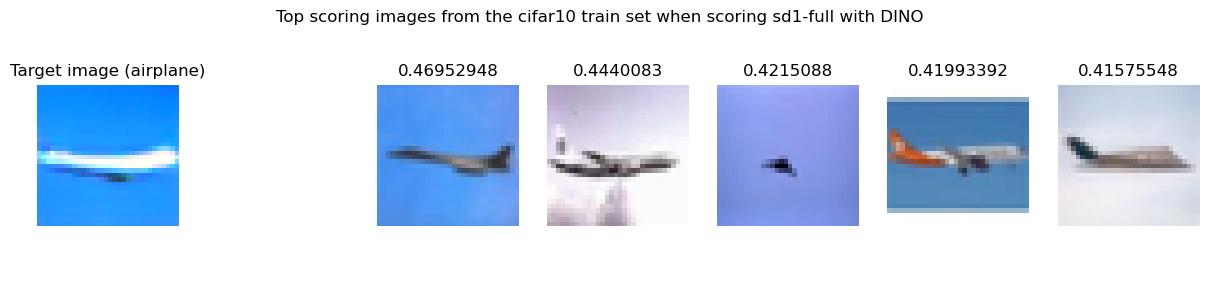

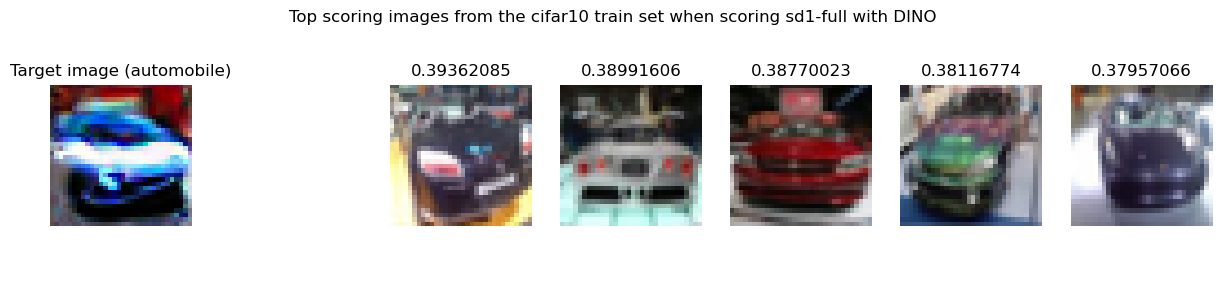

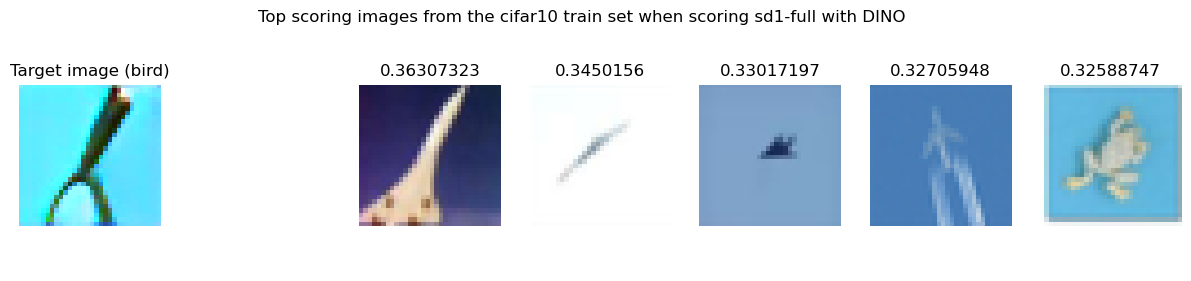

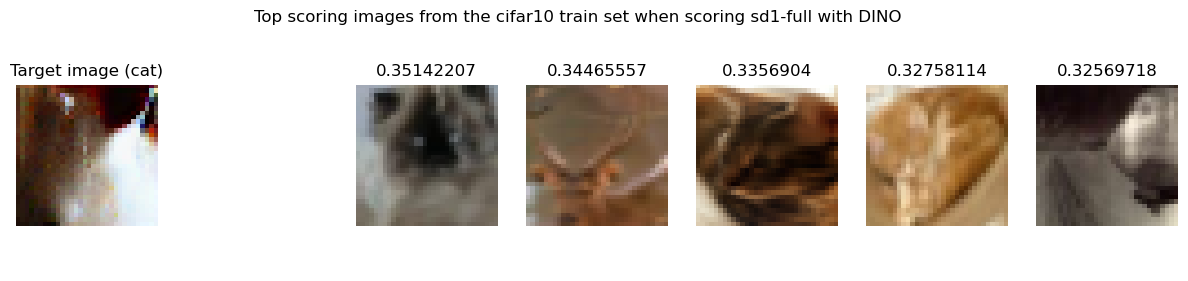

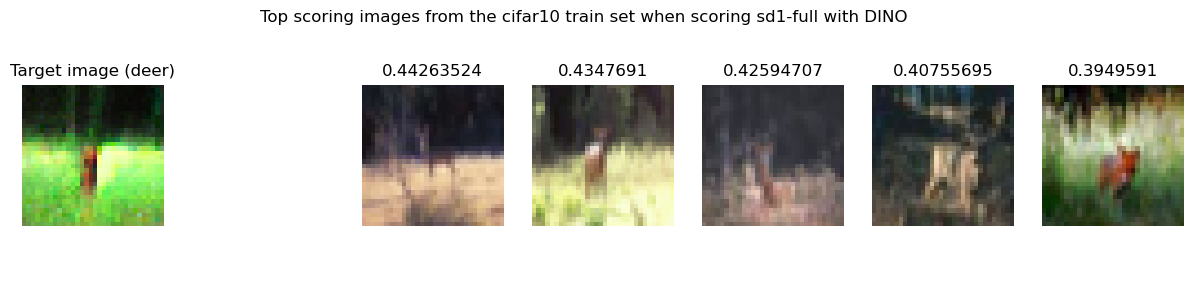

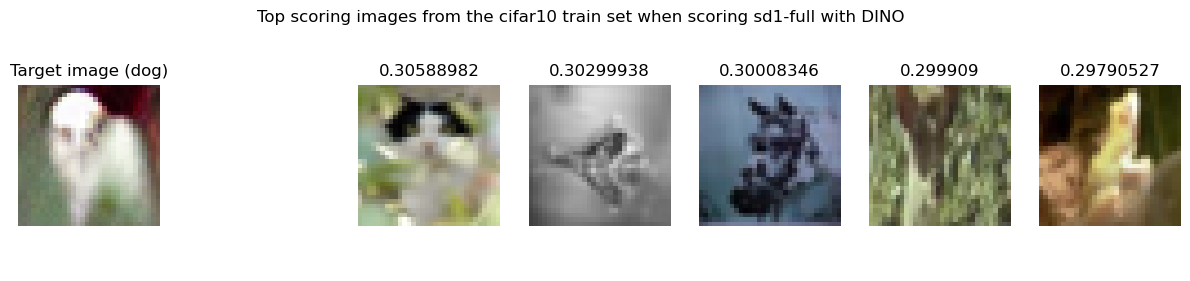

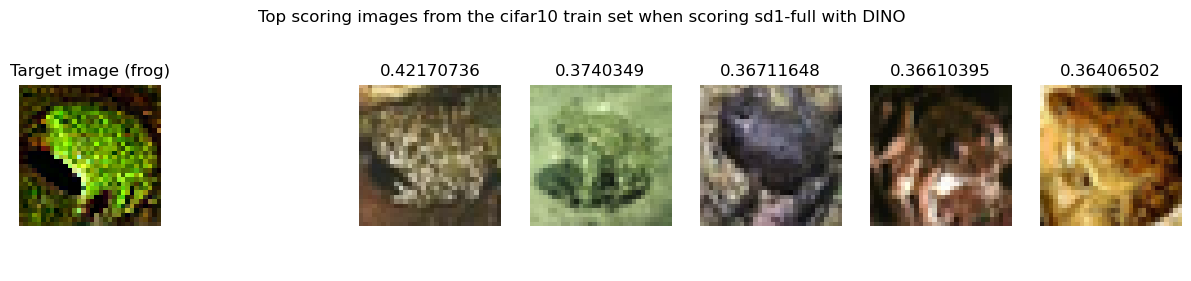

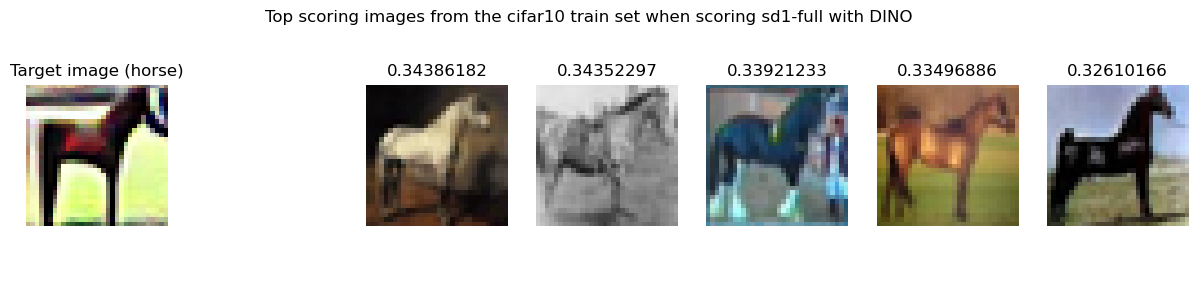

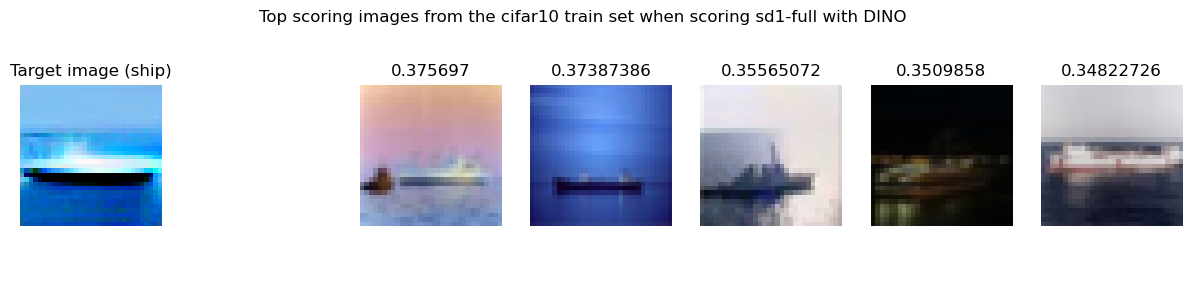

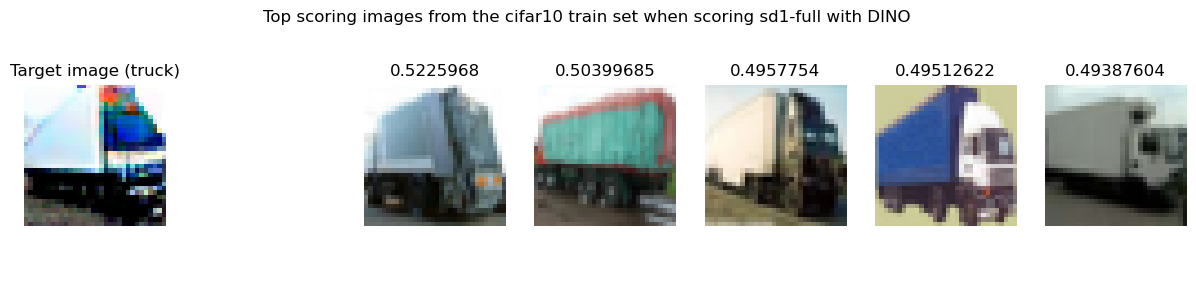

In [9]:
#Adapted from https://github.com/MadryLab/trak/blob/main/examples/cifar_quickstart.ipynb
if RECALCULATE_ATTRIBUTION:
    for i in range(len(prompts)):
        fig, axs = plt.subplots(ncols=7, figsize=(15, 3))
        fig.suptitle(f'Top scoring images from the {dataset_type} train set when scoring {MODEL_NAME_CLEAN} with DINO')
        
        axs[0].imshow(generated_images[i])
        
        axs[0].axis('off')
        axs[0].set_title('Target image' + " (" + prompts[i] + ")")
        axs[1].axis('off')
        
        for j in range(len(top_n_indices[i])):
            axs[j + 2].imshow(train_dataset_config.dataset[int(top_n_indices[i][j])]["image"])
            axs[j + 2].axis('off')
            axs[j + 2].set_title(str(top_n_scores[i][j].numpy()))

        fig.show()

## LDS

This section would calculate the LDS scores, however we were not able to calculate enough subset models to get decent data out of this metric, so this code is skipped.

In [10]:
import numpy as np
if RECALCULATE_ATTRIBUTION and CALCULATE_LDS:
    scores = np.zeros((dataset_size,len(generated_dataset_config.dataset)))
    for i in range(len(generated_dataset_config.dataset)):
        scores[:,i] = calculate_DINO_Attribution(generated_dataset_config.dataset[i][generated_dataset_config.image_column], dataset_size, return_raw_scores=True).numpy()
    np.save("DINO_SCORES_TEMP",scores)
#else:
    #scores = np.load("DINO_SCORES_TEMP.npy")

In [11]:
if CALCULATE_LDS: 
    from torch.utils.data import DataLoader
    from utils.config import Model_Config
    model_config = Model_Config(
        project_config=project_config,
        MODEL_TYPE=Model_Type_Enum.FULL,
        DATASET_TYPE=dataset_type,
    )
    model_path = model_config.getModelDirectory()
    tokenizer, _, _, _ = model_config.loadModelComponents(model_path)
    generated_dataset = generated_dataset_config.preprocess(tokenizer)
    # DataLoaders creation:
    generated_dataloader = DataLoader(
        generated_dataset,
        shuffle=False,
        collate_fn=generated_dataset_config.collate_fn,
        batch_size=1,
    )

In [12]:
if CALCULATE_LDS: 
    from LDS.LDS_Utils import LDS
    lds_score = LDS(project_config=project_config,
        training_dataset_config=train_dataset_config,
        generated_dataset_dataloader=generated_dataloader,
        training_dataset_type=dataset_type,
        generated_dataset_size=len(generated_dataset_config.dataset),
        attribution_scores_tau=scores,
        seed=42)
    print(lds_score)

## Counter Factuals

Next we use the attribution scores generated above to produce "counter factuals".
This works as follows:
- Pick a target test image
- Create a subset of the dataset where the top scoring images for this test image have been removed
- Generate a new "counter factual model" by training on this subset
- Use the "counter factual model" to generate a new image (the "counter factual image") using the same seed and prompt as the original target image


Ideally, the counter factual image will be very different from the original target image, since this means that the data that contributed the most to its creation has been removed.

In [13]:
from utils.dataset_utils import Dataset_Generator
cfds = Dataset_Generator(
    project_config=project_config,
    dataset_type=dataset_type,
)

In [14]:
prompts = train_dataset_config.class_captions

The target image will be printed after this code block.

TARGET_CLASS: frog
TARGET_SEED: 1
TARGET_IMAGE: 6


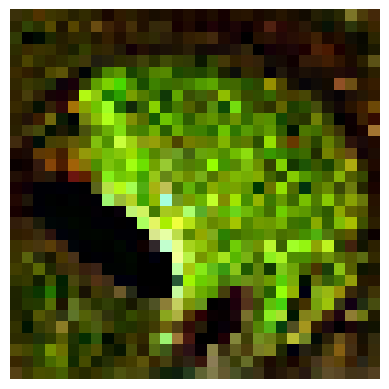

In [15]:
if dataset_type == Dataset_Type_Enum.CIFAR10:
    TARGET_CLASS = "frog"
if dataset_type == Dataset_Type_Enum.CIFAR2:
    TARGET_CLASS = "horse"

assert(TARGET_CLASS in prompts)
print(f"TARGET_CLASS: {TARGET_CLASS}")
print(f"TARGET_SEED: {SEED_TO_PREVIEW}")

TARGET_IMAGE = prompts.index(TARGET_CLASS) #Seed 1, frog
print(f"TARGET_IMAGE: {TARGET_IMAGE}")
plt.axis('off')
plt.imshow(generated_images[TARGET_IMAGE])

top_n_i, top_n_s = calculate_DINO_Attribution(generated_images[TARGET_IMAGE],1000)
top_n_i = top_n_i.numpy()

In [16]:
top_n_i_list = top_n_i.tolist()

Next we generate the "Class Conformity" statistics. This looks at the number of images in the top 1,10,100 and 1000 that match the class of the target image.

Class conformity % (1): 100.0
Class conformity % (10): 100.0
Class conformity % (100): 98.0
Class conformity % (1000): 95.5


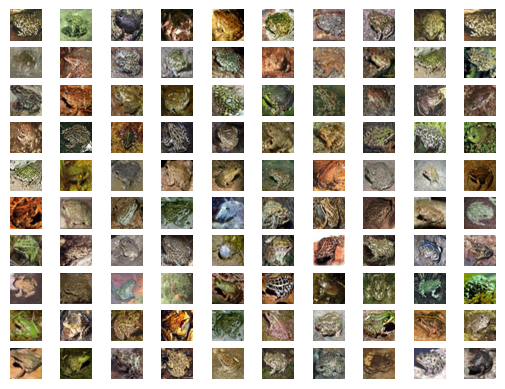

In [17]:
one_class_conformity = 0
ten_class_conformity = 0
hundred_class_conformity = 0
thousand_class_conformity = 0
num_images_per_axis = 10

for i in range(len(top_n_i_list)):
    if train_dataset_config.dataset[top_n_i_list[i]][train_dataset_config.caption_column] == TARGET_CLASS:
        if i<1:
            one_class_conformity += 1
        if i<10:
            ten_class_conformity += 1
        if i<100:
            hundred_class_conformity += 1
        if i<1000:
            thousand_class_conformity += 1
    
one_class_conformity_percentage = (one_class_conformity/1)*100
print(f"Class conformity % (1): {one_class_conformity_percentage}")
ten_class_conformity_percentage = (ten_class_conformity/10)*100
print(f"Class conformity % (10): {ten_class_conformity_percentage}")
hundred_class_conformity_percentage = (hundred_class_conformity/100)*100
print(f"Class conformity % (100): {hundred_class_conformity_percentage}")
thousand_class_conformity_percentage = (thousand_class_conformity/1000)*100
print(f"Class conformity % (1000): {thousand_class_conformity_percentage}")

for i in range(num_images_per_axis**2):
    plt.subplot(num_images_per_axis, num_images_per_axis, i+1)
    plt.axis('off')
    plt.imshow(train_dataset_config.dataset[top_n_i_list[i]][train_dataset_config.image_column])

num_images_per_axis = 10
for i in range(num_images_per_axis**2):
    plt.subplot(num_images_per_axis, num_images_per_axis, i+1)
    plt.axis('off')
    plt.imshow(train_dataset_config.dataset[top_n_i_list[i]][train_dataset_config.image_column])

Next we create the subset of the dataset with these top 1000 removed. This creates a config for the local CIFAR10 dataset.

In [18]:
counter_factual_model_name = f"DINO_{MODEL_NAME_CLEAN}_{TARGET_CLASS}_seed_{SEED_TO_PREVIEW}"

cfds.create_counterfactual_config(counter_factual_model_name,top_n_i_list)
print(" ")

Config DINO_sd1-full_frog_seed_1 already exists!
 


This next block prints out the config name.

Copy this into ```training_scripts/\<dataset_name\>/train_sd1_(model_type)_counterfactuals.sh``` under the ```config_name``` line and run the script (details in the main project readme). We don't do this in this directly in this notebook since it will take 8-10 hours to train. Then come back and rerun this notebook from scratch.

In [19]:
print(counter_factual_model_name)

DINO_sd1-full_frog_seed_1


In [20]:
from counter_factuals.counter_factuals_utils import Counter_Factual_Image_Generator

Make sure you have follows the instructions above! 

This block will error out the first time you run this because the counter factual model does not exist yet.

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


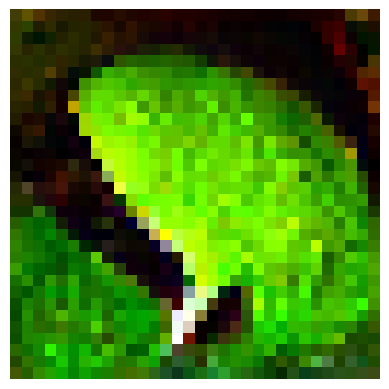

In [21]:
cfig = Counter_Factual_Image_Generator(
    project_config=project_config,
    counter_factual_model_name=counter_factual_model_name,
    model_type=model_type,
    dataset_type=dataset_type,
)

image = cfig.generate_counter_factual_image(
    seed=SEED_TO_PREVIEW,
    image_class=TARGET_CLASS,
    save_image=True,
    prompts=prompts,
)

plt.axis('off')
plt.imshow(image)